# Flight Price Prediction

In [31]:
# Import necessary libraries
import pandas as pd
import numpy as np

In [3]:
# Load the dataset
df = pd.read_csv("flight.csv")

In [4]:
# Inspect the dataset
df.head()

,Unnamed: 0,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


## EDA

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [6]:
df['stops'].unique()

array(['zero', 'one', 'two_or_more'], dtype=object)

In [75]:
numerical = ['duration', 'days_left']
categorical = list(df.dtypes[df.dtypes == 'object'].index)

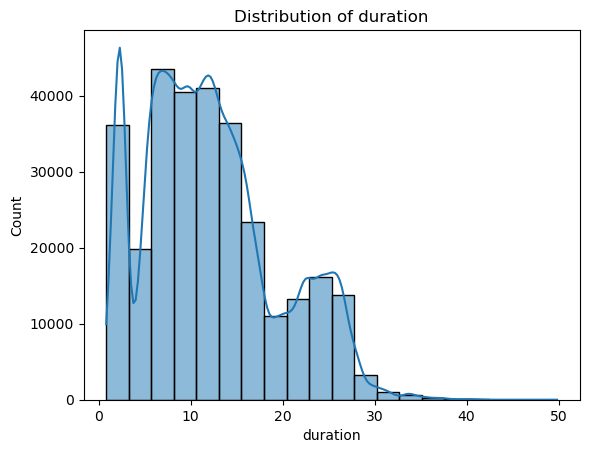

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["duration"], kde=True, bins=20)
plt.title(f'Distribution of duration')
plt.show()

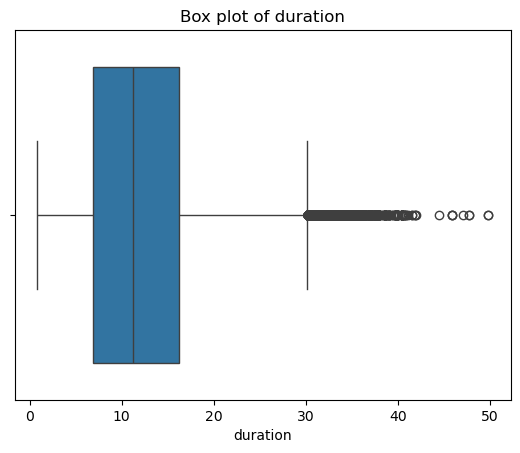

In [9]:
sns.boxplot(x=df["duration"])
plt.title(f'Box plot of duration')
plt.show()

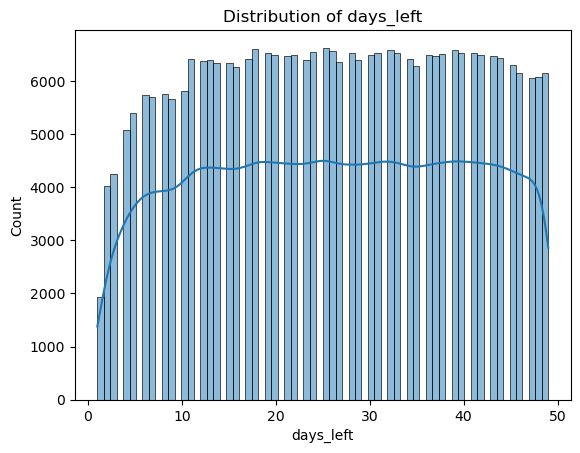

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df["days_left"], kde=True)
plt.title(f'Distribution of days_left')
plt.show()

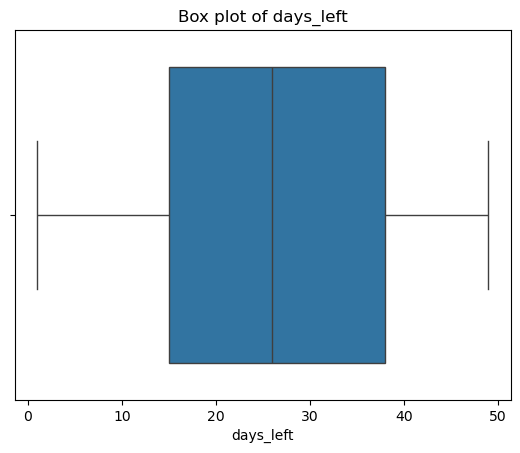

In [11]:
sns.boxplot(x=df["days_left"])
plt.title(f'Box plot of days_left')
plt.show()

In [12]:
df["days_left"].nunique()

49

In [13]:
for column in categorical:
    print(df[column].value_counts())
    print()
    print(f"unique values of {column}: {df[column].nunique()}")
    print()

airline
Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: count, dtype: int64

unique values of airline: 6

flight
UK-706     3235
UK-772     2741
UK-720     2650
UK-836     2542
UK-822     2468
           ... 
SG-9923       1
6E-6474       1
6E-865        1
G8-705        1
G8-107        1
Name: count, Length: 1561, dtype: int64

unique values of flight: 1561

source_city
Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: count, dtype: int64

unique values of source_city: 6

departure_time
Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Night        1306
Name: count, dtype: int64

unique values of departure_time: 6

stops
one            250863
zero            36004
two_or_more     13286
Name: count, dtype: int64

unique values of stops: 3

arrival_time
Night            915

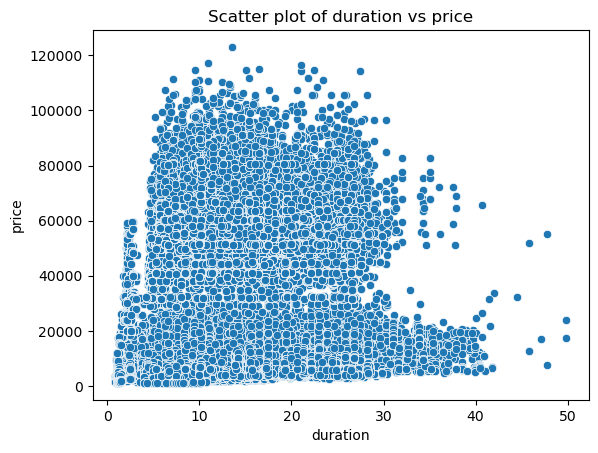

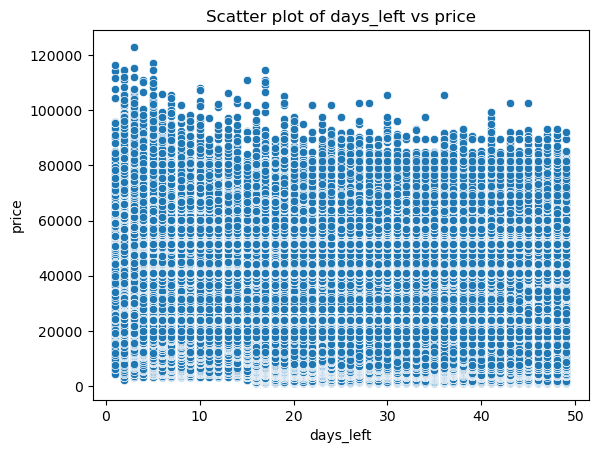

In [14]:
for column in df.drop('price', axis=1)[numerical]: 
    sns.scatterplot(x=df[column], y=df['price'])
    plt.title(f'Scatter plot of {column} vs price')
    plt.show()

In [15]:
df.price.describe()

count    300153.000000
mean      20889.660523
std       22697.767366
min        1105.000000
25%        4783.000000
50%        7425.000000
75%       42521.000000
max      123071.000000
Name: price, dtype: float64

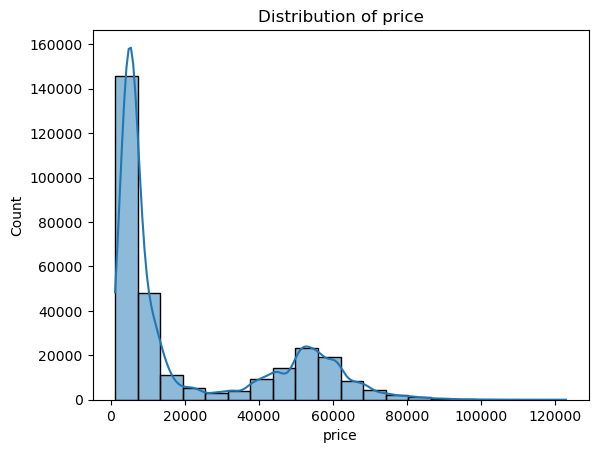

In [16]:
sns.histplot(df["price"], kde=True, bins=20)
plt.title(f'Distribution of price')
plt.show()

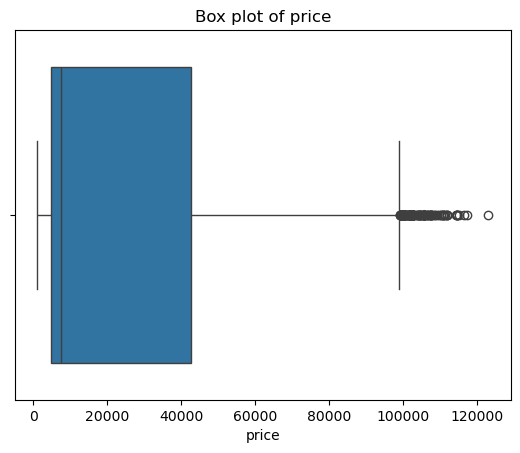

In [17]:
sns.boxplot(x=df["price"])
plt.title(f'Box plot of price')
plt.show()

## Data Preprocessing

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300153 entries, 0 to 300152
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300153 non-null  int64  
 1   airline           300153 non-null  object 
 2   flight            300153 non-null  object 
 3   source_city       300153 non-null  object 
 4   departure_time    300153 non-null  object 
 5   stops             300153 non-null  object 
 6   arrival_time      300153 non-null  object 
 7   destination_city  300153 non-null  object 
 8   class             300153 non-null  object 
 9   duration          300153 non-null  float64
 10  days_left         300153 non-null  int64  
 11  price             300153 non-null  int64  
dtypes: float64(1), int64(3), object(8)
memory usage: 27.5+ MB


In [71]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import numpy as np

def preprocess_data(
    df, target_column, categorical_columns, numerical_columns=None,
    drop_columns=None, encode=True, scale=False, log_transform=False
):
    """
    Modular preprocessing for data splitting, encoding, scaling, and feature engineering.

    Args:
    - df (DataFrame): The dataset.
    - target_column (str): Name of the target column.
    - categorical_columns (list): List of categorical columns to encode.
    - numerical_columns (list): List of numerical columns to scale.
    - drop_columns (list): Columns to drop before training.
    - encode (bool): Whether to apply one-hot encoding.
    - scale (bool): Whether to scale numerical features.
    - log_transform (bool): Whether to apply log-transform to the target.
    - custom_features (dict): Custom feature engineering logic as {column_name: func}.

    Returns:
    - X_train, X_val, X_test: Preprocessed feature matrices.
    - y_train, y_val, y_test: Target vectors.
    - transformers: Fitted transformers (encoder, scaler) for reuse.
    """
    # Separate features and target
    X = df.drop(columns=[target_column])
    y = df[target_column]

    # Apply log transformation to the target if specified
    if log_transform:
        y = np.log1p(y)  # log1p to handle zero or near-zero values

    # Drop specified columns
    if drop_columns:
        X = X.drop(columns=drop_columns)

    # Split the data
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Initialize transformers
    transformers = {}
    
    # Apply encoding for categorical columns
    if encode and categorical_columns:
        encoder = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
            ],
            remainder='passthrough'
        )
        X_train = encoder.fit_transform(X_train)
        X_val = encoder.transform(X_val)
        X_test = encoder.transform(X_test)
        transformers['encoder'] = encoder

    # Apply scaling for numerical columns
    if scale and numerical_columns:
        scaler = StandardScaler()
        X_train[:, -len(numerical_columns):] = scaler.fit_transform(X_train[:, -len(numerical_columns):])
        X_val[:, -len(numerical_columns):] = scaler.transform(X_val[:, -len(numerical_columns):])
        X_test[:, -len(numerical_columns):] = scaler.transform(X_test[:, -len(numerical_columns):])
        transformers['scaler'] = scaler

    return X_train, X_val, X_test, y_train, y_val, y_test, transformers


In [81]:
# Initial necessary preprocessing
X_train, X_val, X_test, y_train, y_val, y_test, _ = preprocess_data(df,
                                                                    'price',
                                                                    categorical,
                                                                    drop_columns='Unnamed: 0')

## Training and Evaluation

In [23]:
# Train and evaluate models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


def train_and_evaluate_models(models, X_train, y_train, X_val, y_val):
    """
    Train and evaluate multiple regression models.

    Args:
    - models (list): List of tuples containing model names and initialized model objects.
    - X_train (array-like): Training feature matrix.
    - y_train (array-like): Training target vector.
    - X_val (array-like): Validation feature matrix.
    - y_val (array-like): Validation target vector.

    Returns:
    - results_df (DataFrame): DataFrame summarizing model performance.
    """
    results = []

    for name, model in models:
        # Train the model
        model.fit(X_train, y_train)

        # Predict on validation set
        y_val_pred = model.predict(X_val)

        # Evaluate metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
        r2 = r2_score(y_val, y_val_pred)

        # Store results
        results.append({'Model': name, 'RMSE': rmse, 'R-squared': r2})

        print(f"Trained {name}: RMSE = {rmse:.4f}, R^2 = {r2:.4f}")

    # Convert results to a DataFrame
    results_df = pd.DataFrame(results)
    return results_df


## Model Selection

In [34]:
from xgboost import XGBRegressor

models = [
    ('Linear Regression', LinearRegression()),
    ('Ridge Regression', Ridge(alpha=1.0)),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('XGBoost', XGBRegressor(random_state=42))
]

In [26]:
train_and_evaluate_models(models, X_train, y_train, X_val, y_val)

Trained Linear Regression: RMSE = 747206953635.0421, R^2 = -1078566569248688.3750
Trained Ridge Regression: RMSE = 6228.4046, R^2 = 0.9251
Trained Random Forest: RMSE = 2522.4180, R^2 = 0.9877
Trained XGBoost: RMSE = 3506.0900, R^2 = 0.9763


,Model,RMSE,R-squared
0,Linear Regression,7.472070e+11,-1.078567e+15
1,Ridge Regression,6.228405e+03,9.250591e-01
2,Random Forest,2.522418e+03,9.877087e-01
3,XGBoost,3.506090e+03,9.762529e-01


In [35]:
# Reducing skewness and bring the data distribution closer to normal
price_logs = np.log1p(df.price)

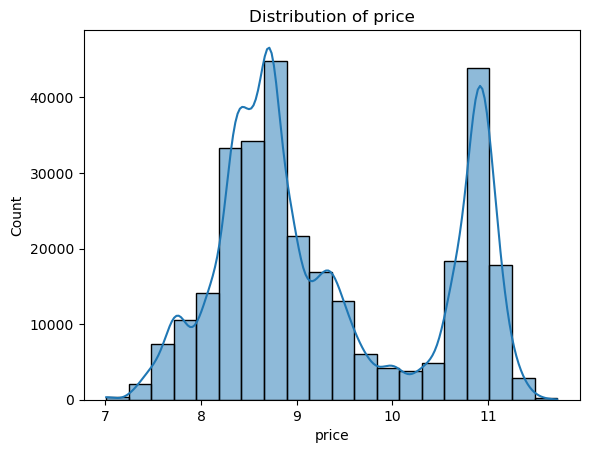

In [28]:
sns.histplot(price_logs, kde=True, bins=20)
plt.title(f'Distribution of price')
plt.show()

In [76]:
# Dropping  flight Column could improve model performance
# Since flight is likely a unique or near-unique identifier, it may not provide generalizable information for prediction.
# Log-transform the target to reduce skewness
categorical.remove('flight') 
X_train, X_val, X_test, y_train, y_val, y_test, _ = preprocess_data(df, 'price', categorical, drop_columns='flight', log_transform=True)

In [ ]:
train_and_evaluate_models(models, X_train, y_train, X_val, y_val)


In [47]:
train_and_evaluate_models(models, X_train, y_train, X_val, y_val)

Trained Linear Regression: RMSE = 0.3216, R^2 = 0.9167
Trained Ridge Regression: RMSE = 0.3216, R^2 = 0.9167
Trained Random Forest: RMSE = 0.1256, R^2 = 0.9873
Trained XGBoost: RMSE = 0.1768, R^2 = 0.9748


,Model,RMSE,R-squared
0,Linear Regression,0.321594,0.916690
1,Ridge Regression,0.321594,0.916690
2,Random Forest,0.125632,0.987286
3,XGBoost,0.176785,0.974825


## Outlier Elimination

In [73]:
# Based on EDA, Boxplots show that outliers are the following:
# - Price > 100000
# - duration > 30

def outlier_removal(df):
    """
    Remove rows where price > 100000 or duration > 30.

    Args:
    - df (DataFrame): Input dataset.

    Returns:
    - DataFrame with outliers removed.
    """
    df = df[df['price'] <= 100000]
    df = df[df['duration'] <= 30]
    return df


In [82]:
df_without_oulier = outlier_removal(df)

# Preprocess data
X_train, X_val, X_test, y_train, y_val, y_test, _ = preprocess_data(df_without_oulier,
                                                                    'price',
                                                                    categorical,
                                                                    drop_columns=['Unnamed: 0', 'flight'],
                                                                   log_transform=True)

In [83]:
# Train and evaulate again the new data
train_and_evaluate_models(models, X_train, y_train, X_val, y_val)

Trained Linear Regression: RMSE = 0.3235, R^2 = 0.9157
Trained Ridge Regression: RMSE = 0.3235, R^2 = 0.9157
Trained Random Forest: RMSE = 0.1350, R^2 = 0.9853
Trained XGBoost: RMSE = 0.1808, R^2 = 0.9737


,Model,RMSE,R-squared
0,Linear Regression,0.323496,0.915715
1,Ridge Regression,0.323463,0.915732
2,Random Forest,0.134959,0.985330
3,XGBoost,0.180753,0.973686


In [84]:
df.shape

(300153, 12)

In [ ]:
custom_features = {
    'price_per_duration': lambda X: X['price'] / (X['duration'] + 1),
    'is_long_duration': lambda X: (X['duration'] > 30).astype(int),
    'price_category': lambda X: pd.cut(
        X['price'], bins=[0, 50000, 100000, float('inf')], labels=['budget', 'standard', 'premium']
    ),
    'days_left_category': lambda X: pd.cut(
        X['days_left'], bins=[0, 7, 30, float('inf')], labels=['last_minute', 'standard', 'early']
    ),
    'log_duration': lambda X: np.log1p(X['duration'])
}
